# 1. Comprender el dataset

Link del dataset_ https://www.bbci.de/competition/iv/desc_2b.pdf

In [1]:
!pip install mne gdown scipy numpy pandas seaborn matplotlib torch torchvision scikit-learn torchsummary


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 27.9 MB/s eta 0:00:00


In [2]:
#Descarga directamente el dataset de BCI Competition IV 2a
!wget https://www.bbci.de/competition/download/competition_iv/BCICIV_2b_gdf.zip

--2025-10-16 05:46:48--  https://www.bbci.de/competition/download/competition_iv/BCICIV_2b_gdf.zip
Resolving www.bbci.de (www.bbci.de)... 141.23.71.83
Connecting to www.bbci.de (www.bbci.de)|141.23.71.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 226710550 (216M) [application/zip]
Saving to: ‘BCICIV_2b_gdf.zip’

BCICIV_2b_gdf.zip   100%[===================>] 216.21M  30.6MB/s    in 7.7s    

2025-10-16 05:46:57 (28.1 MB/s) - ‘BCICIV_2b_gdf.zip’ saved [226710550/226710550]



In [3]:
#Descomprime el archivo descargado en la MISMA CARPETA LOCAL (En mi caso /Proyect_EEG)
!mkdir -p cleaned_data

# Descomprime los datos en crudo en raw_data
!unzip BCICIV_2b_gdf.zip -d raw_data

Archive:  BCICIV_2b_gdf.zip
  inflating: raw_data/B0101T.gdf     
  inflating: raw_data/B0102T.gdf     
  inflating: raw_data/B0103T.gdf     
  inflating: raw_data/B0104E.gdf     
  inflating: raw_data/B0105E.gdf     
  inflating: raw_data/B0201T.gdf     
  inflating: raw_data/B0202T.gdf     
  inflating: raw_data/B0203T.gdf     
  inflating: raw_data/B0204E.gdf     
  inflating: raw_data/B0205E.gdf     
  inflating: raw_data/B0301T.gdf     
  inflating: raw_data/B0302T.gdf     
  inflating: raw_data/B0303T.gdf     
  inflating: raw_data/B0304E.gdf     
  inflating: raw_data/B0305E.gdf     
  inflating: raw_data/B0401T.gdf     
  inflating: raw_data/B0402T.gdf     
  inflating: raw_data/B0403T.gdf     
  inflating: raw_data/B0404E.gdf     
  inflating: raw_data/B0405E.gdf     
  inflating: raw_data/B0501T.gdf     
  inflating: raw_data/B0502T.gdf     
  inflating: raw_data/B0503T.gdf     
  inflating: raw_data/B0504E.gdf     
  inflating: raw_data/B0505E.gdf     
  inflating: raw_data/

In [4]:
# Crear carpetas para datos limpios de las dos primeras sesiones
!mkdir -p cleaned_data/first_session
!mkdir -p cleaned_data/second_session
!mkdir -p cleaned_data/fourth_session
!mkdir -p cleaned_data/five_session

## 1.1 Importar librerias y generando el dataset

In [5]:
#Importamos todas las librerias necesarias para procesar nuestro dataste y entrenar nuestro modelo de Deep Learning

import os #Para manejo de archivos y directorios
import mne #Para procesamiento de señales EEG
import math
import copy #Para hacer copias profundas de objetos
import gdown #Sirve para descargar archivos de Google Drive
import random
import scipy.io #Para trabajar con archivos .mat
import numpy as np #Para operaciones numéricas
import pandas as pd
import seaborn as sn #Para visualización de datos
import matplotlib.pyplot as plt #Para visualización de datos

# Torch
import torch
import torch.nn as nn #Para construir redes neuronales
import torch.optim as optim #Para optimizadores
import torch.nn.functional as F #Para funciones de activación y pérdida

from torchsummary import summary #Para resumir modelos de PyTorch
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, random_split

# Scikit-Learn
from sklearn.feature_selection import mutual_info_classif #Para selección de características
from sklearn.metrics import confusion_matrix, accuracy_score #Para evaluar el rendimiento del modelo
from sklearn.model_selection import train_test_split #Para dividir los datos en conjuntos de entrenamiento y prueba

## 1.2 Ejemplo de plot B0101T

In [34]:

#Ejemplo señal B0101T.gdf
raw_B010XT = mne.io.read_raw_gdf('raw_data/B0101T.gdf', eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)
raw_B010XT.info

Extracting EDF parameters from /content/raw_data/B0101T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/tmp/ipython-input-2138396436.py:2: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw_B010XT = mne.io.read_raw_gdf('raw_data/B0101T.gdf', eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)


<Info | 8 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 6 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2005-10-25 09:35:11 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
 subject_info: <subject_info | his_id: B01, sex: 0, last_name: X, birthday: 1984-12-01>
>

Debemos entender cuales son los nombres que contienen a los eog...

In [35]:
# Convierte las anotaciones textuales en eventos numéricos
raw_B010XT.annotations
events = mne.events_from_annotations(raw_B010XT)
events[1]

Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]


{np.str_('1023'): 1,
 np.str_('1077'): 2,
 np.str_('1078'): 3,
 np.str_('1079'): 4,
 np.str_('1081'): 5,
 np.str_('276'): 6,
 np.str_('277'): 7,
 np.str_('32766'): 8,
 np.str_('768'): 9,
 np.str_('769'): 10,
 np.str_('770'): 11}

In [36]:
# Crear epochs para los eventos de interés (10, 11) desde 0 a 4 segundos
epochs = mne.Epochs(raw_B010XT, events[0], event_id=[10,11], tmin=0, tmax=4, reject=None, baseline=None, preload=True)

# Extraer los datos y las etiquetas de las epochs
first_session_data= epochs.get_data(copy=True)

# Etiquetas de las primeras sesiones
first_session_labels = epochs.events[:,-1]

Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 120 events and 1001 original time points ...
0 bad epochs dropped


In [37]:
#Obtenemos la info de cada epoch
epochs.get_data().shape

(120, 6, 1001)

Como podemos observar, son 6 canales, de los cuales 3 son pertenecientes a los EEG y otros 3 pertenecientes a EOG.


In [38]:
#Leemos cuales son sus nombres
channel_names = epochs.ch_names
print(channel_names)

['EEG:C3', 'EEG:Cz', 'EEG:C4', 'EOG:ch01', 'EOG:ch02', 'EOG:ch03']


Ahora si eliminamos los datos de las señales de oculograma pertencientes a ['EOG:ch01', 'EOG:ch02', 'EOG:ch03']

In [39]:
#Si sale error recordar que solo se puede hacer esto una vez al realizar la accion
raw_B010XT.drop_channels(['EOG:ch01', 'EOG:ch02', 'EOG:ch03'])


<RawGDF | B0101T.gdf, 3 x 604803 (2419.2 s), ~13.9 MiB, data loaded>

Mostramos los datos del dataset usado:

Using matplotlib as 2D backend.


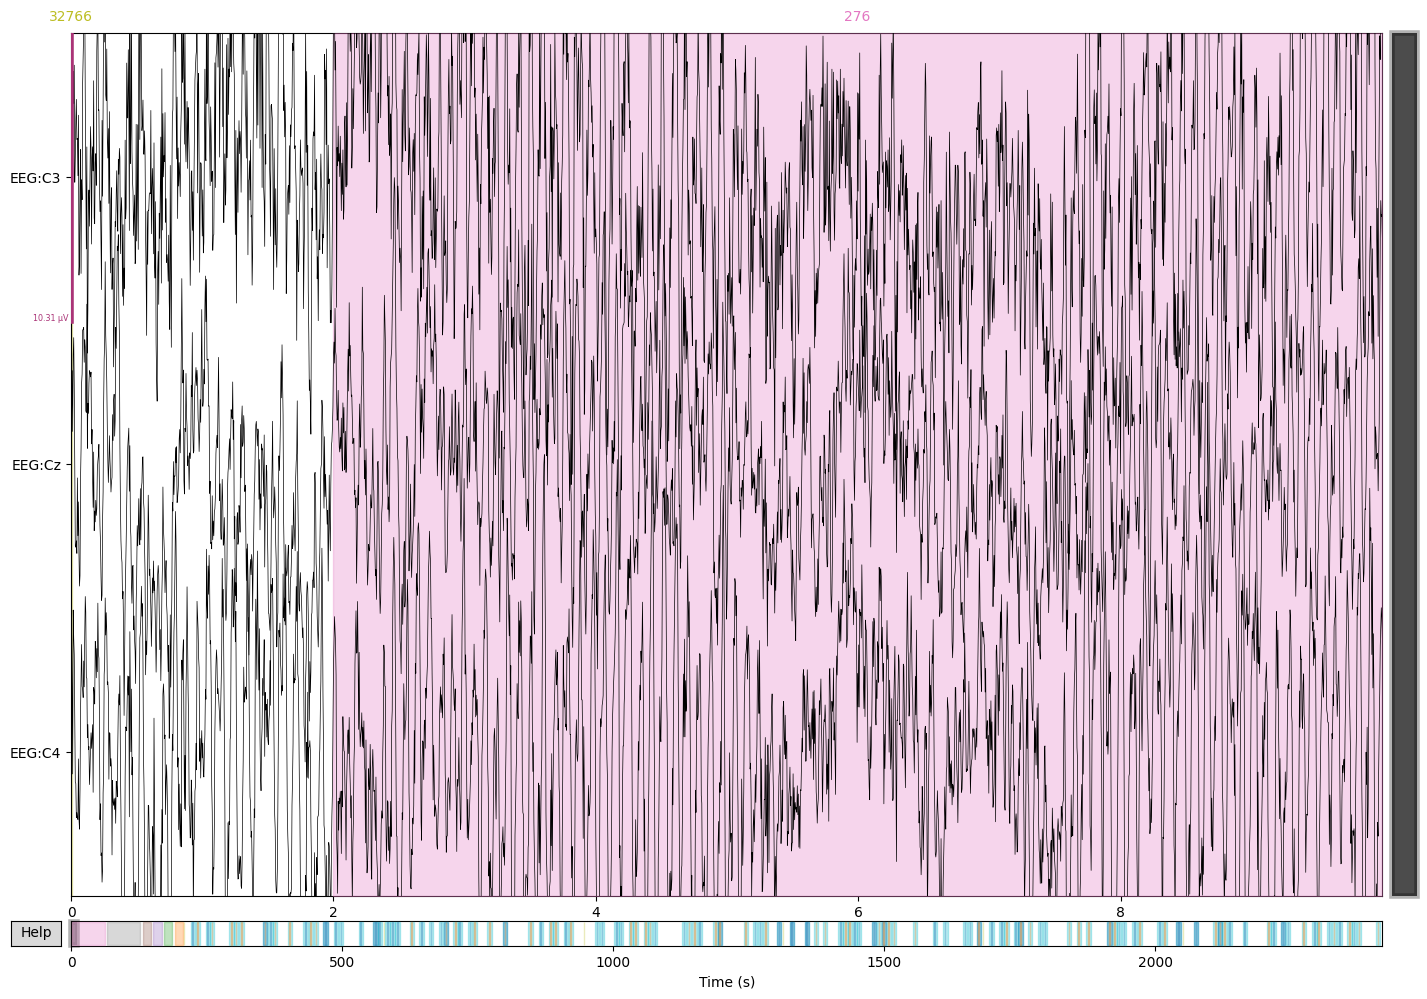

In [40]:
#Plot de la data
fig = raw_B010XT.plot(scalings='auto', show=False)
fig.set_size_inches(15, 10)
plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


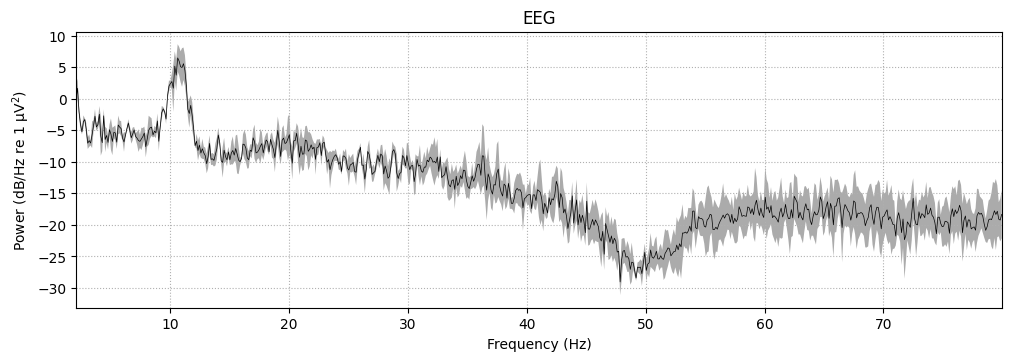

In [41]:
raw_B010XT.plot_psd(tmin=0, tmax=60, fmin=2, fmax=80, average=True, spatial_colors=False);

Filtramos igual que el BCI Competition IV 2a para que obtengamos los valores en las bandas que nos interesan

In [42]:
raw_B010XT.filter(l_freq=8, h_freq=30, method='iir')
raw_B010XT.notch_filter(freqs=50)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



<RawGDF | B0101T.gdf, 3 x 604803 (2419.2 s), ~13.9 MiB, data loaded>

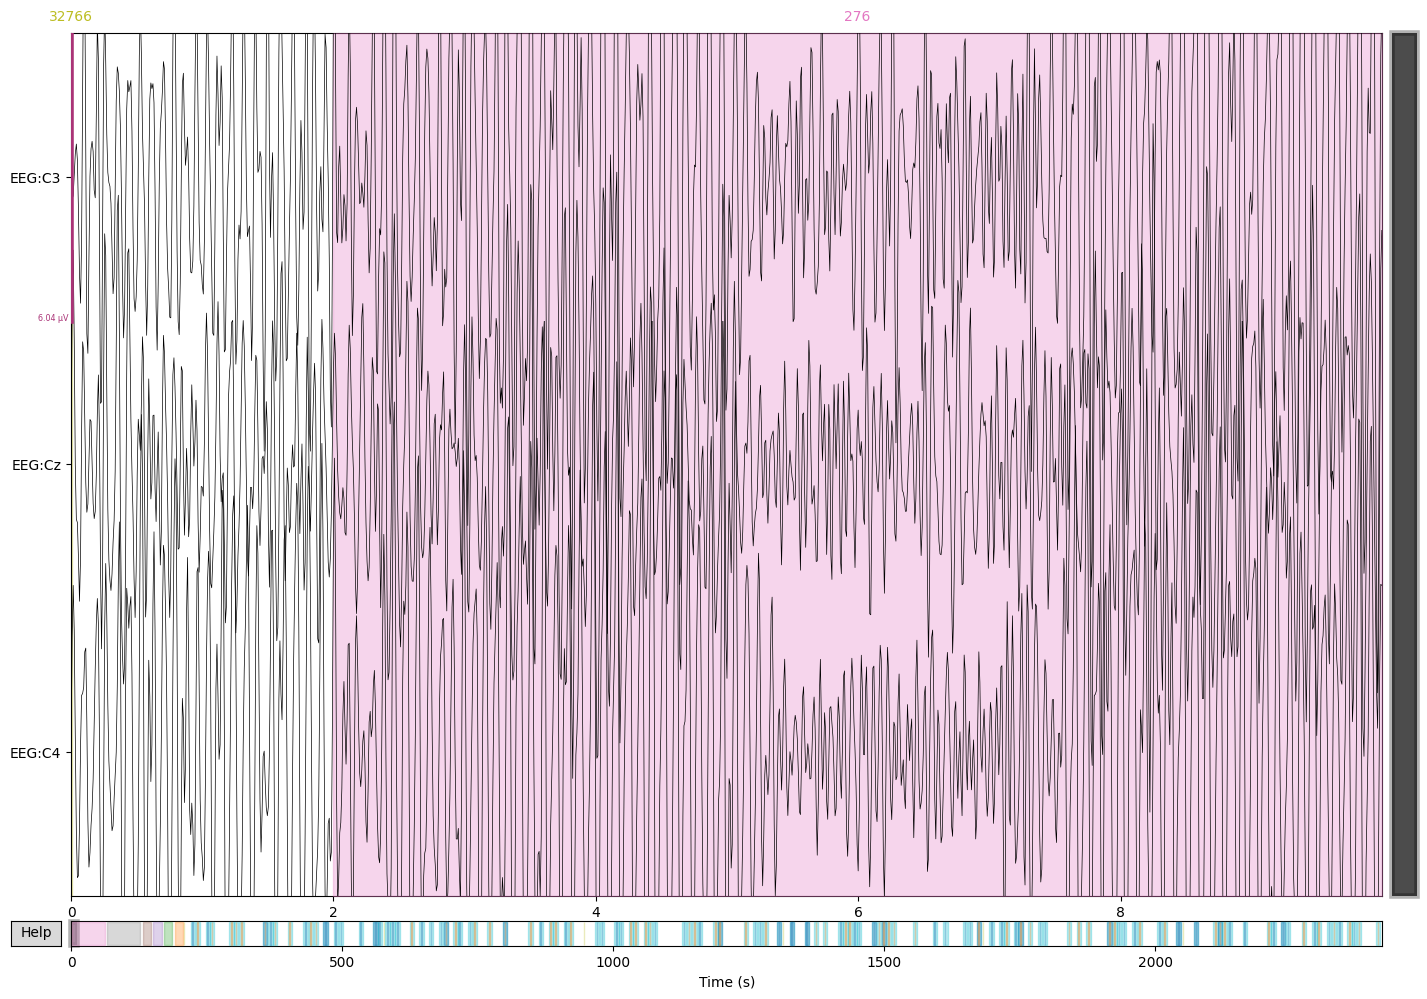

In [43]:
#Plot de la data
fig = raw_B010XT.plot(scalings='auto', show=False)
fig.set_size_inches(15, 10)
plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


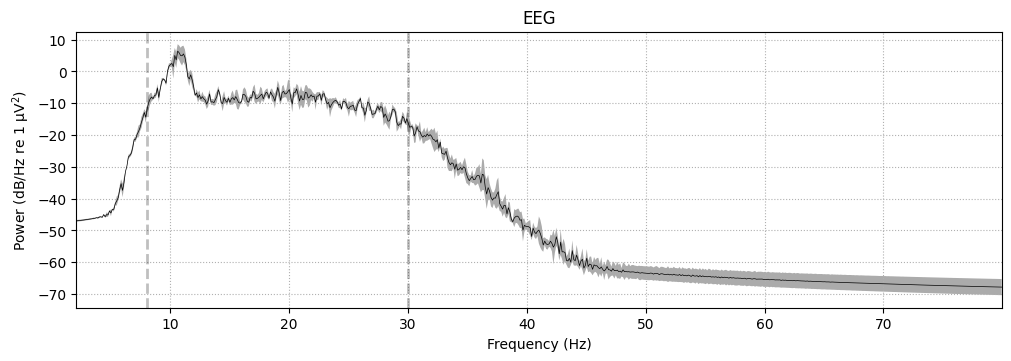

In [44]:
raw_B010XT.plot_psd(tmin=0, tmax=60, fmin=2, fmax=80, average=True, spatial_colors=False);

Ahora mostramos los trials que ocurrieron para el primer recording y obtenemos su PSD para identificar el decremento de la amplitud en las bandas beta y mu (sobretodo beta), acorde a las ERDs.

Tiempo de cada epoch [0.    0.004 0.008 ... 3.992 3.996 4.   ]


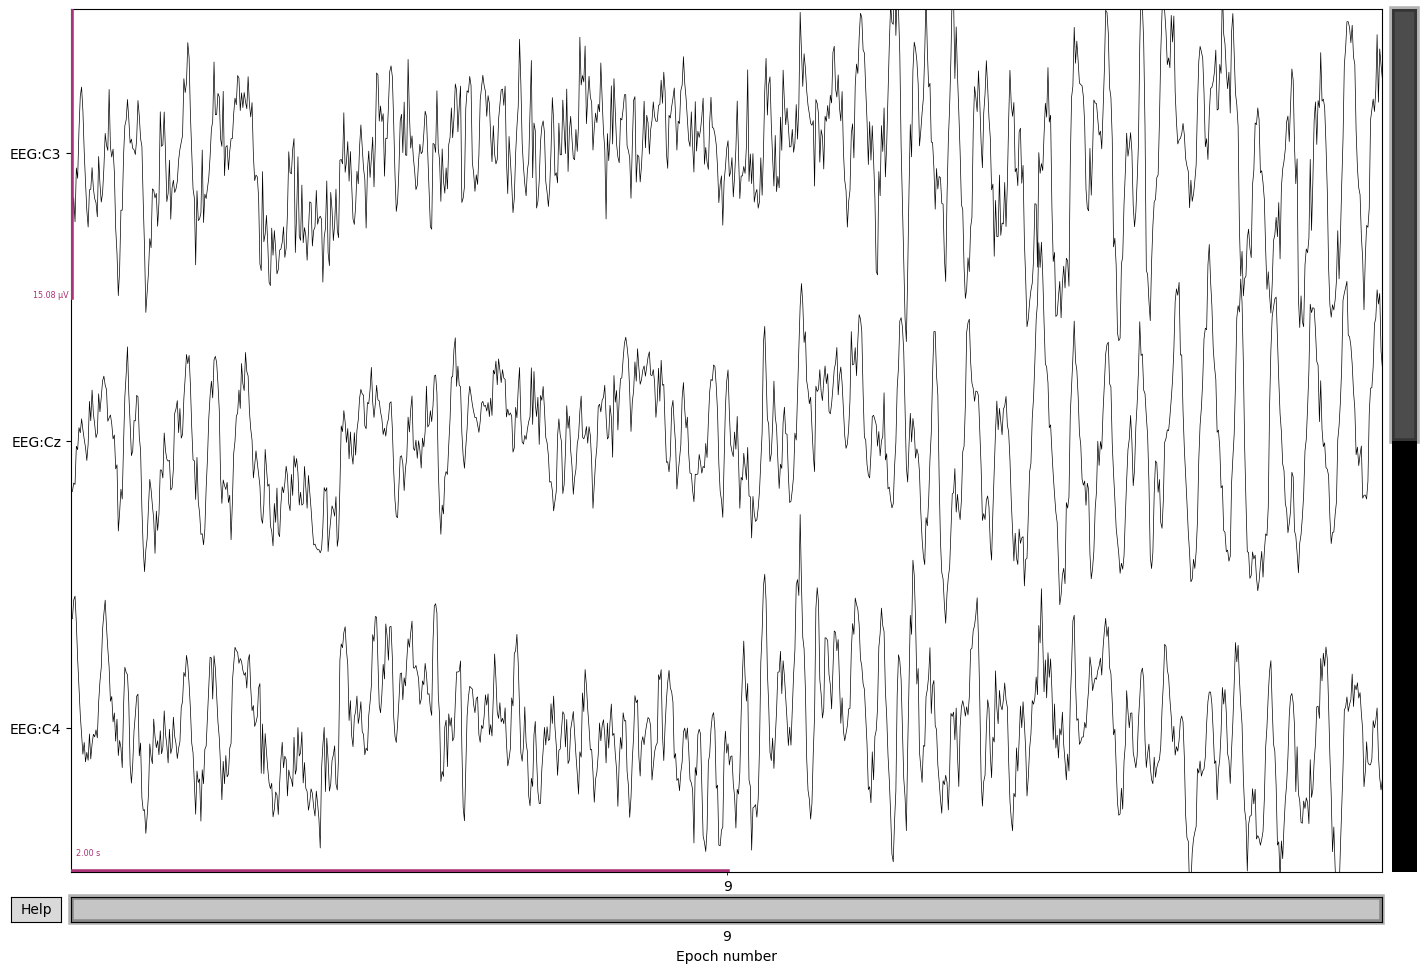

In [45]:
# Mostrar el primer trial (epoch 0) con los 6 canales
fig = epochs[0].plot(n_channels=3,scalings='auto',title='Trial 0 - 6 canales', show=False)
fig.set_size_inches(15, 10)

# Obtener frecuencia de muestreo
sfreq = epochs.info['sfreq']

# Array con tiempos relativos desde el evento, debería ir de 0 a 4 sa fs=250 Hz
print("Tiempo de cada epoch", epochs[0].times)

Effective window size : 1.024 (s)
PSDs shape: (120, 6, 36), freqs shape: (36,)
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


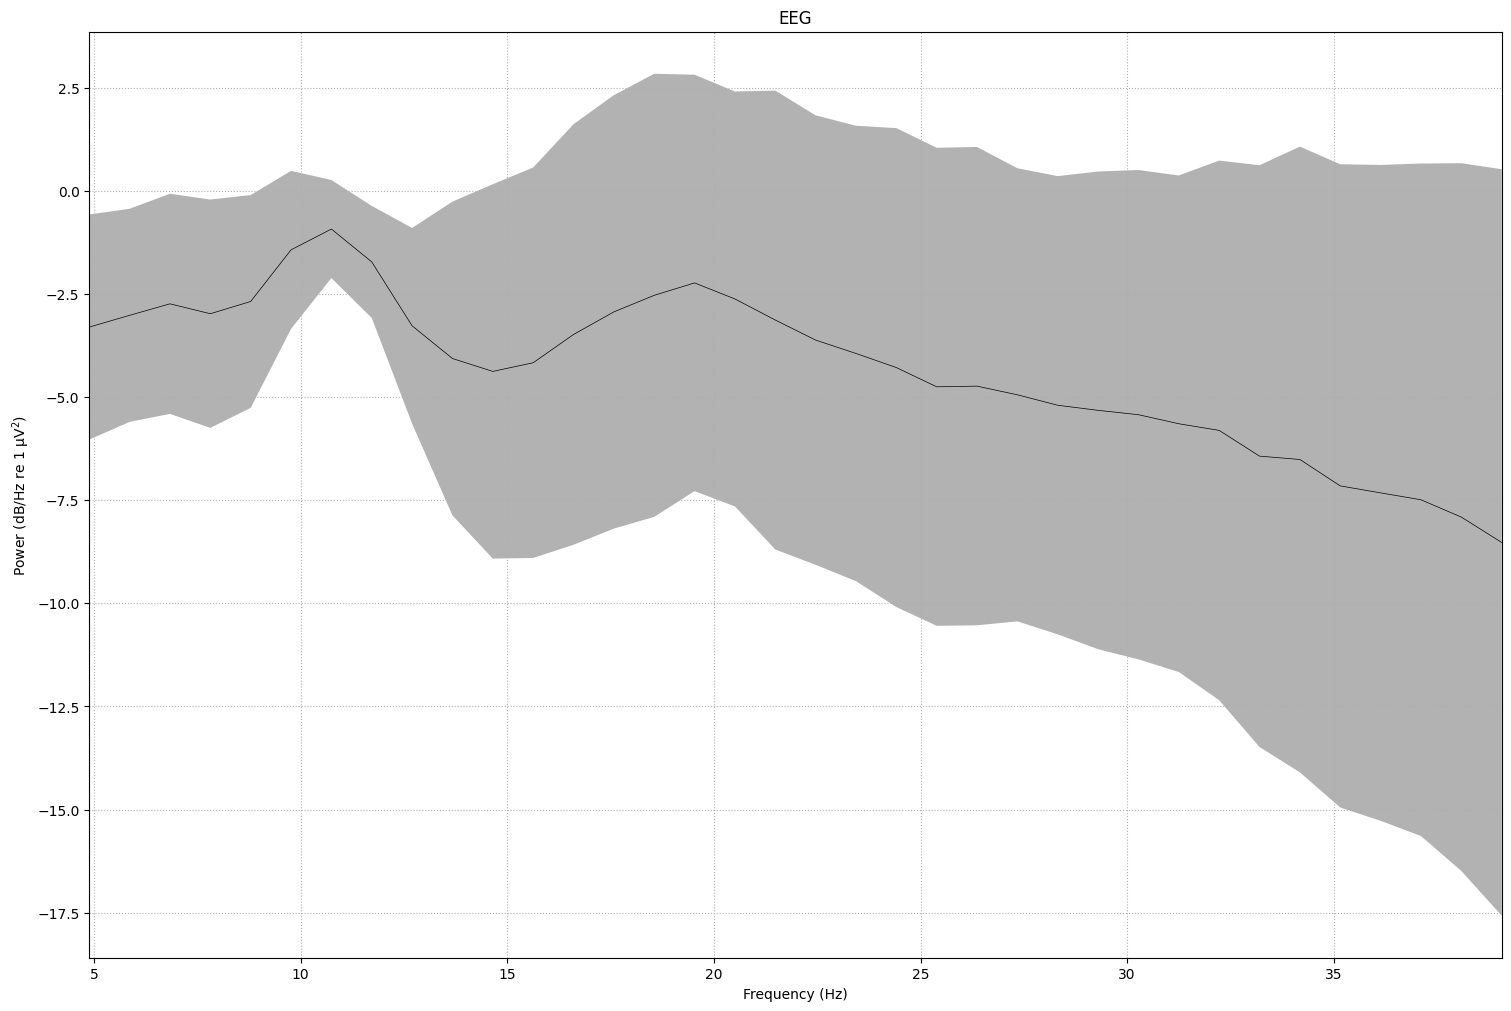

In [46]:
# Calcular la PSD con el método Welch (puedes usar multitaper también)
epo_spectrum = epochs.compute_psd(method='welch', fmin=4, fmax=40, n_fft=256)

# Obtener datos PSD y sus frecuencias
psds, freqs = epo_spectrum.get_data(return_freqs=True)
print(f"PSDs shape: {psds.shape}, freqs shape: {freqs.shape}")

# Graficar el PSD promedio sobre todos los epochs (por canal)
# average=True: promedio de los 288 trials (no cada trial individual).
fig=epo_spectrum.plot(average=True, dB=True, spatial_colors=True)
fig.set_size_inches(15, 10)
plt.show()



Es normal que exista gran variabilidad en los datos, ya que recordemos que solo tenemos 3 canales no como en el BCI competition IV 2a que tenemos 22.

# 2. Procesamiento de recordings

## 2.1 Primera sesión

En el dataset BCI Competition IV 2a, los archivos están nombrados según el tipo de sesión:

| Sufijo | Significado               | Ejemplo       | Contenido / Uso                                                                 |
|--------|---------------------------|---------------|---------------------------------------------------------------------------------|
| T      | Training (Entrenamiento)  | B0101T.gdf, B0102T.gdf | Contienen todas las etiquetas de clase y se usan para entrenar el modelo.        |
| E      | Evaluation / Test (Prueba)| B0104E.gdf, B0105E.gdf | No contienen todas las etiquetas de clase; se usan para evaluar el desempeño del modelo. |


In [6]:
#NOTA: MNE tiene su propio sistema de logging (mensajes de información), por defecto.

# Definir las rutas de las carpetas
raw_data_folder = "raw_data/"
cleaned_data_folder = "cleaned_data/first_session/"
files = os.listdir(raw_data_folder) # devuelve una lista con los nombres de los archivos enlistados: ['A01T.gdf', 'A01E.gdf', 'A02T.gdf', ...]

# Aquí se está filtrando la lista de archivos para quedarse solo con los que terminan en .T.gdf (archivos de entrenamiento)
filtered_files = [file for file in files if file.endswith('01T.gdf')]

# Inicializar una lista para almacenar los datos
raw_list = []

# Iterar sobre los archivos filtrados y cargar los datos
for file in filtered_files:
    file_path = os.path.join(raw_data_folder, file) # Construir la ruta completa del archivo (.../.../...)

    # Cargar el archivo GDF usando MNE y especificar los canales EOG
    raw = mne.io.read_raw_gdf(file_path, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)

    # Eliminar los canales EOG del raw data para cada
    raw.drop_channels(['EOG:ch01', 'EOG:ch02', 'EOG:ch03'])

    # High Pass Filtering 8-30 Hz
    raw.filter(l_freq=8, h_freq=30, method='iir')

    # Notch filter for Removal of Line Voltage
    raw.notch_filter(freqs=50)

    # Guardar el archivo limpio en formato .fif en la carpeta cleaned_data/first_session
    new_file_path = os.path.join(cleaned_data_folder, file[:-4] + '.fif')
    raw.save(new_file_path, overwrite=True)

    # Añadir el objeto raw a la lista
    raw_list.append(raw)

# Concatenar si hay archivos cargados
if raw_list:
    final_raw = mne.concatenate_raws(raw_list)

    # Guardar archivo concatenado en .fif
    new_file_path = os.path.join(cleaned_data_folder, 'First_Session_Subjects.fif')
    final_raw.save(new_file_path, overwrite=True)
else:
    print("No se encontraron archivos .T.gdf en la carpeta raw_data.")

Extracting EDF parameters from /content/raw_data/B0801T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...


/tmp/ipython-input-4291800830.py:19: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)


Reading 0 ... 787728  =      0.000 ...  3150.912 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Writing /content/cleaned_data/first_session/B0801T.fif


/tmp/ipython-input-4291800830.py:32: RuntimeWarning: This filename (/content/cleaned_data/first_session/B0801T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/first_session/B0801T.fif
[done]
Extracting EDF parameters from /content/raw_data/B0301T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/tmp/ipython-input-4291800830.py:19: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Writing /content/cleaned_data/first_session/B0301T.fif
Closing /content/cleaned_data/first_session/B0301T.fif
[done]
Extrac

/tmp/ipython-input-4291800830.py:32: RuntimeWarning: This filename (/content/cleaned_data/first_session/B0301T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)
/tmp/ipython-input-4291800830.py:19: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Writing /content/cleaned_data/first_session/B0601T.fif
Closing /content/cleaned_data/first_session/B0601T.fif
[done]
Extrac

/tmp/ipython-input-4291800830.py:32: RuntimeWarning: This filename (/content/cleaned_data/first_session/B0601T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)
/tmp/ipython-input-4291800830.py:19: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Writing /content/cleaned_data/first_session/B0701T.fif
Closing /content/cleaned_data/first_session/B0701T.fif
[done]
Extrac

/tmp/ipython-input-4291800830.py:32: RuntimeWarning: This filename (/content/cleaned_data/first_session/B0701T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)
/tmp/ipython-input-4291800830.py:19: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Writing /content/cleaned_data/first_session/B0401T.fif
Closing /content/cleaned_data/first_session/B0401T.fif
[done]
Extrac

/tmp/ipython-input-4291800830.py:32: RuntimeWarning: This filename (/content/cleaned_data/first_session/B0401T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)
/tmp/ipython-input-4291800830.py:19: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Writing /content/cleaned_data/first_session/B0901T.fif


/tmp/ipython-input-4291800830.py:32: RuntimeWarning: This filename (/content/cleaned_data/first_session/B0901T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/first_session/B0901T.fif
[done]
Extracting EDF parameters from /content/raw_data/B0101T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/tmp/ipython-input-4291800830.py:19: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Writing /content/cleaned_data/first_session/B0101T.fif


/tmp/ipython-input-4291800830.py:32: RuntimeWarning: This filename (/content/cleaned_data/first_session/B0101T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/first_session/B0101T.fif
[done]
Extracting EDF parameters from /content/raw_data/B0201T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/tmp/ipython-input-4291800830.py:19: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Writing /content/cleaned_data/first_session/B0201T.fif
Closing /content/cleaned_data/first_session/B0201T.fif
[done]
Extrac

/tmp/ipython-input-4291800830.py:32: RuntimeWarning: This filename (/content/cleaned_data/first_session/B0201T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)
/tmp/ipython-input-4291800830.py:19: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Writing /content/cleaned_data/first_session/B0501T.fif
Closing /content/cleaned_data/first_session/B0501T.fif
[done]


/tmp/ipython-input-4291800830.py:32: RuntimeWarning: This filename (/content/cleaned_data/first_session/B0501T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Writing /content/cleaned_data/first_session/First_Session_Subjects.fif


/tmp/ipython-input-4291800830.py:43: RuntimeWarning: This filename (/content/cleaned_data/first_session/First_Session_Subjects.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  final_raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/first_session/First_Session_Subjects.fif
[done]


In [7]:
#Anotacion de los eventos que ocurren
events = mne.events_from_annotations(final_raw)

# Crear epochs para los eventos de interés (10,11) desde 0 a 4 segundos
epochs = mne.Epochs(final_raw, events[0], event_id=[10,11], tmin=0.5, tmax=4, reject=None, baseline=None, preload=True)

# Extraer los datos y las etiquetas de las epochs
first_session_data = epochs.get_data(copy=True)

# Etiquetas de las primeras sesiones
first_session_labels = epochs.events[:,-1]

print("First Session Dataset shape:", first_session_data.shape)
print("Total etiquetas cargadas:", first_session_labels.shape)

Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Not setting metadata
1120 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1120 events and 876 original time points ...
0 bad epochs dropped
First Session Dataset shape: (1120, 3, 876)
Total etiquetas cargadas: (1120,)


## 2.2 Cuarta session

Link: https://www.bbci.de/competition/iv/results/ds2b/true_labels.zip

Descargamos y descomprimimos para obtener los labels de la sesión que sirve para evaluar.

In [8]:
!wget https://www.bbci.de/competition/iv/results/ds2b/true_labels.zip
!unzip true_labels.zip -d fourth_session_labels

--2025-10-16 05:48:06--  https://www.bbci.de/competition/iv/results/ds2b/true_labels.zip
Resolving www.bbci.de (www.bbci.de)... 141.23.71.83
Connecting to www.bbci.de (www.bbci.de)|141.23.71.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14660 (14K) [application/zip]
Saving to: ‘true_labels.zip’

true_labels.zip     100%[===================>]  14.32K  --.-KB/s    in 0s      

2025-10-16 05:48:07 (308 MB/s) - ‘true_labels.zip’ saved [14660/14660]

Archive:  true_labels.zip
  inflating: fourth_session_labels/B0401T.mat  
  inflating: fourth_session_labels/B0403T.mat  
  inflating: fourth_session_labels/B0601T.mat  
  inflating: fourth_session_labels/B0202T.mat  
  inflating: fourth_session_labels/B0603T.mat  
  inflating: fourth_session_labels/B0104E.mat  
  inflating: fourth_session_labels/B0105E.mat  
  inflating: fourth_session_labels/B0802T.mat  
  inflating: fourth_session_labels/B0305E.mat  
  inflating: fourth_session_labels/B0501T.mat  
  inflating: 

In [9]:
mat_data = scipy.io.loadmat("/content/fourth_session_labels/B0104E.mat")  # ejemplo
print(mat_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'classlabel'])


In [10]:
raw_data_folder = 'raw_data/'
cleaned_data_folder = 'cleaned_data/fourth_session/'
mat_folder = 'fourth_session_labels/'

# Filtrar archivos .mat para las etiquetas (ejemplo 4E.mat)
mat_files = os.listdir(mat_folder)
filtered_math_labels = [file for file in mat_files if file.endswith('04E.mat')]

# Filtrar archivos .gdf para la sesión (ejemplo 4E.gdf)
files = os.listdir(raw_data_folder)
filtered_files = [file for file in files if file.endswith('04E.gdf')]

raw_list = []
fourth_session_labels = np.array([])

# Iteración sobre los .gdf
for file in filtered_files:
    file_path = os.path.join(raw_data_folder, file)

    # Leer datos
    raw = mne.io.read_raw_gdf(file_path,
                              eog=['EOG-left', 'EOG-central', 'EOG-right'],
                              preload=True)
    raw.drop_channels(['EOG:ch01', 'EOG:ch02', 'EOG:ch03'])
    raw.filter(l_freq=8, h_freq=30, method='iir')

    # Guardar .fif
    new_file_path = os.path.join(cleaned_data_folder, file[:-4] + '.fif')
    raw.save(new_file_path, overwrite=True)

    raw_list.append(raw)

    # Cargar labels del .mat correspondiente
    mat_file_name = file.replace('.gdf', '.mat')
    mat_file_path = os.path.join(mat_folder, mat_file_name)
    print(f"data:{file}, label:{mat_file_name}")

    if os.path.exists(mat_file_path):
        mat_data = scipy.io.loadmat(mat_file_path)
        class_labels = mat_data.get('classlabel', [])

        if class_labels.size > 0:
            class_labels_array = np.array(class_labels, dtype=int).flatten()
            fourth_session_labels = np.concatenate(
                (fourth_session_labels, class_labels_array)
            )
            print(f"Etiquetas cargadas: {class_labels_array.shape[0]}")
        else:
            print(f"Warning: 'classlabel' not found or empty in {mat_file_name}.")
    else:
        print(f"Warning: {mat_file_name} not found.")

# Concatenamos todos los raws
final_raw = mne.concatenate_raws(raw_list)
new_file_path = os.path.join(cleaned_data_folder, 'Fourth_Session_Subjects.fif')
final_raw.save(new_file_path, overwrite=True)

Extracting EDF parameters from /content/raw_data/B0804E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 474834  =      0.000 ...  1899.336 secs...


/tmp/ipython-input-3638845600.py:21: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path,


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Writing /content/cleaned_data/fourth_session/B0804E.fif
Closing /content/cleaned_data/fourth_session/B0804E.fif
[done]
data:B0804E.gdf, label:B0804E.mat
Etiquetas cargadas: 160
Extracting EDF parameters from /content/raw_data/B0404E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 467478  =      0.000 ...  1869.912 secs...


/tmp/ipython-input-3638845600.py:29: RuntimeWarning: This filename (/content/cleaned_data/fourth_session/B0804E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)
/tmp/ipython-input-3638845600.py:21: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path,


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Writing /content/cleaned_data/fourth_session/B0404E.fif
Closing /content/cleaned_data/fourth_session/B0404E.fif
[done]
data:B0404E.gdf, label:B0404E.mat
Etiquetas cargadas: 160
Extracting EDF parameters from /content/raw_data/B0704E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 470343  =      0.000 ...  1881.372 secs...


/tmp/ipython-input-3638845600.py:29: RuntimeWarning: This filename (/content/cleaned_data/fourth_session/B0404E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)
/tmp/ipython-input-3638845600.py:21: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path,


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Writing /content/cleaned_data/fourth_session/B0704E.fif
Closing /content/cleaned_data/fourth_session/B0704E.fif
[done]
data:B0704E.gdf, label:B0704E.mat
Etiquetas cargadas: 160
Extracting EDF parameters from /content/raw_data/B0104E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 466313  =      0.000 ...  1865.252 secs...


/tmp/ipython-input-3638845600.py:29: RuntimeWarning: This filename (/content/cleaned_data/fourth_session/B0704E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)
/tmp/ipython-input-3638845600.py:21: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path,


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Writing /content/cleaned_data/fourth_session/B0104E.fif
Closing /content/cleaned_data/fourth_session/B0104E.fif
[done]
data:B0104E.gdf, label:B0104E.mat
Etiquetas cargadas: 160
Extracting EDF parameters from /content/raw_data/B0304E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 464674  =      0.000 ...  1858.696 secs...


/tmp/ipython-input-3638845600.py:29: RuntimeWarning: This filename (/content/cleaned_data/fourth_session/B0104E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)
/tmp/ipython-input-3638845600.py:21: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path,


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Writing /content/cleaned_data/fourth_session/B0304E.fif
Closing /content/cleaned_data/fourth_session/B0304E.fif
[done]
data:B0304E.gdf, label:B0304E.mat
Etiquetas cargadas: 160
Extracting EDF parameters from /content/raw_data/B0504E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 417019  =      0.000 ...  1668.076 secs...


/tmp/ipython-input-3638845600.py:29: RuntimeWarning: This filename (/content/cleaned_data/fourth_session/B0304E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)
/tmp/ipython-input-3638845600.py:21: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path,


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Writing /content/cleaned_data/fourth_session/B0504E.fif
Closing /content/cleaned_data/fourth_session/B0504E.fif
[done]
data:B0504E.gdf, label:B0504E.mat
Etiquetas cargadas: 160
Extracting EDF parameters from /content/raw_data/B0204E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 361829  =      0.000 ...  1447.316 secs...


/tmp/ipython-input-3638845600.py:29: RuntimeWarning: This filename (/content/cleaned_data/fourth_session/B0504E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)
/tmp/ipython-input-3638845600.py:21: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path,


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Writing /content/cleaned_data/fourth_session/B0204E.fif
Closing /content/cleaned_data/fourth_session/B0204E.fif
[done]
data:B0204E.gdf, label:B0204E.mat
Etiquetas cargadas: 120
Extracting EDF parameters from /content/raw_data/B0904E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 466802  =      0.000 ...  1867.208 secs...


/tmp/ipython-input-3638845600.py:29: RuntimeWarning: This filename (/content/cleaned_data/fourth_session/B0204E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)
/tmp/ipython-input-3638845600.py:21: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path,


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Writing /content/cleaned_data/fourth_session/B0904E.fif
Closing /content/cleaned_data/fourth_session/B0904E.fif
[done]
data:B0904E.gdf, label:B0904E.mat
Etiquetas cargadas: 160
Extracting EDF parameters from /content/raw_data/B0604E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 469990  =      0.000 ...  1879.960 secs...


/tmp/ipython-input-3638845600.py:29: RuntimeWarning: This filename (/content/cleaned_data/fourth_session/B0904E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)
/tmp/ipython-input-3638845600.py:21: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path,


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Writing /content/cleaned_data/fourth_session/B0604E.fif
Closing /content/cleaned_data/fourth_session/B0604E.fif
[done]
data:B0604E.gdf, label:B0604E.mat
Etiquetas cargadas: 160


/tmp/ipython-input-3638845600.py:29: RuntimeWarning: This filename (/content/cleaned_data/fourth_session/B0604E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Writing /content/cleaned_data/fourth_session/Fourth_Session_Subjects.fif


/tmp/ipython-input-3638845600.py:56: RuntimeWarning: This filename (/content/cleaned_data/fourth_session/Fourth_Session_Subjects.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  final_raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/fourth_session/Fourth_Session_Subjects.fif
[done]


[PosixPath('/content/cleaned_data/fourth_session/Fourth_Session_Subjects.fif')]

In [11]:
from scipy.io import loadmat

# Cargar el archivo .mat que tiene las etiquetas
mat_data = loadmat("fourth_session_labels/B0104E.mat")   # ajusta con tu archivo real
labels_mat = mat_data['classlabel'].squeeze()  # (160,)
print(labels_mat.shape)  # debería dar (160,)

print("Total etiquetas:", labels_mat.shape[0])
print("Ejemplo de clases únicas:", np.unique(labels_mat))

(160,)
Total etiquetas: 160
Ejemplo de clases únicas: [1 2]


In [12]:
events, event_dict = mne.events_from_annotations(final_raw)
events[1]

# Mostrar los eventos únicos encontrados
print("Eventos encontrados:", event_dict)

print(events.shape)
print(events[:5])  # Primeros 5 eventos

epochs = mne.Epochs(final_raw, events, event_id=11, tmin=0.5, tmax=4, reject=None, baseline=None, preload=None)

fourth_session_data = epochs.get_data(copy=True)

print("\nFourth Session Dataset shape:", fourth_session_data.shape)
print("Total etiquetas cargadas:", fourth_session_labels.shape)

Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
Eventos encontrados: {np.str_('1023'): 1, np.str_('1077'): 2, np.str_('1078'): 3, np.str_('1079'): 4, np.str_('1081'): 5, np.str_('276'): 6, np.str_('277'): 7, np.str_('32766'): 8, np.str_('768'): 9, np.str_('781'): 10, np.str_('783'): 11}
(4566, 3)
[[    0     0     8]
 [  499     0     6]
 [16749     0     7]
 [32999     0     5]
 [37999     0     4]]
Not setting metadata
1400 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1400 events and 876 original time points ...
0 bad epochs dropped

Fourth Session Dataset shape: (1400, 3, 876)
Total etiquetas cargadas: (1400,)


# 4. Entrenamiento y evaluación del modelo

## 4.1 Estructura y preparación de datos

In [13]:
# Choosing Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss Function
criterion = nn.CrossEntropyLoss()

# Normalizing Labels to [0, 1, 2, 3]
y_train = first_session_labels - np.min(first_session_labels)
y_test = fourth_session_labels - np.min(fourth_session_labels)

# Normalizing Input features: z-score(mean=0, std=1)
X_first_session = (first_session_data - np.mean(first_session_data)) / np.std(first_session_data)
X_fourth_session = (fourth_session_data - np.mean(fourth_session_data)) / np.std(fourth_session_data)

X = np.concatenate((X_first_session, X_fourth_session))
y = np.concatenate((y_train, y_test))

# Spliting  Data: 90% for Train and 10% for Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Converting to Tensor
X_train = torch.Tensor(X_train).unsqueeze(1).to(device)
X_test = torch.Tensor(X_test).unsqueeze(1).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

# Creating Tensor Dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Printing the sizes
print("Size of X_train:", X_train.size())
print("Size of X_test:", X_test.size())
print("Size of y_train:", y_train.size())
print("Size of y_test:", y_test.size())

Size of X_train: torch.Size([2268, 1, 3, 876])
Size of X_test: torch.Size([252, 1, 3, 876])
Size of y_train: torch.Size([2268])
Size of y_test: torch.Size([252])


## 4.2 Clase de entrenamiento

In [14]:
#TrainModel es una clase que encapsula el proceso de
#entrenamiento de un modelo de red neuronal utilizando PyTorch.

class TrainModel():
    def __init__(self,):
        # Establece el dispositivo para PyTorch (GPU si está disponible, de lo contrario CPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Método para entrenar el modelo

    # Batch size: número de muestras que se procesan antes de actualizar el modelo
    # Epochs: número de veces que el modelo verá todo el conjunto de datos de entrenamiento

    def train_model(self, model, train_dataset, learning_rate=0.001, batch_size=64, epochs=500):
        model = model.to(self.device) # Mover el modelo al dispositivo adecuado (CPU o GPU)
        criterion = nn.CrossEntropyLoss()

        # Definir el optimizador Adam
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Variables para seguimiento del rendimiento
        highest_train_accuracy = 0.0

        # Bucle de entrenamiento
        for epoch in range(epochs):
            model.train() # train mode - activa dropout y batchnorm si están presentes
            running_loss = 0.0
            correct = 0
            total = 0

            # Iterar sobre los lotes de datos
            for inputs, labels in train_loader:

                # Mover los datos al dispositivo adecuado (CPU o GPU)
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                # Procesos de forward y backward pass
                # y actualización de pesos del modelo
                optimizer.zero_grad() # Limpiar los gradientes acumulados

                #Forward pass: pasamos los datos por el modelo
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                #Backward pass: aplicamos backpropagation
                loss.backward()
                optimizer.step()

                # Estadísticas de pérdida y precisión
                running_loss += loss.item() * inputs.size(0) # Suma la pérdida del lote actual
                _, predicted = torch.max(outputs, 1) # Obtiene las predicciones del modelo

                # Cuenta el número total de etiquetas y las predicciones correctas
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_accuracy = correct / total

            # Actualiza la mejor precisión de entrenamiento si es necesario
            if epoch_accuracy > highest_train_accuracy:
                highest_train_accuracy = epoch_accuracy

            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {(epoch_accuracy*100):.2f}%")

        # Estadísticas finales después del entrenamiento
        average_loss = running_loss / len(train_loader.dataset)
        print("Average Loss:", average_loss)
        print("Highest Train Accuracy:", highest_train_accuracy)

        # Saving model
        torch.save(model.state_dict(), 'eegnet_model.pth')
        return model

## 4.3 Clase de evaluación de modelo

In [15]:
# EvalModel es una clase que encapsula el proceso de evaluación de un modelo de red neuronal utilizando PyTorch.
class EvalModel():
    def __init__(self, model):
        self.model = model.to(device)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Método para probar el modelo en un conjunto de datos de prueba y calcular la precisión de clasificación
    def test_model(self, test_dataset):

        # Poner el modelo en modo de evaluación
        self.model.eval() # Desactiva dropout y batch normalization si están presentes
        correct = 0
        total = 0

        # Crear un DataLoader para el conjunto de datos de prueba
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        # Desactivar el cálculo de gradientes para la evaluación
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calcular y mostrar la precisión
        accuracy = (correct / total) * 100
        print("/------------------------------/")
        print(f"Test Accuracy: {accuracy:.2f}%")
        print("/------------------------------/")
        return accuracy

    #
    def plot_confusion_matrix(self, test_dataset, classes):
        self.model.eval()
        y_pred = []
        y_true = []
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        with torch.no_grad():
            #from: https://github.com/github-copilot/code_referencing?cursor=39e277800e17a96819fae3ffbe2dca5e&editor=vscode
            for entradas, etiquetas in test_loader:
                entradas = entradas.to(self.device)
                etiquetas = etiquetas.to(self.device)

                salidas = self.model(entradas)
                _, predicho = torch.max(salidas.data, 1)

                y_pred.append(predicho.item())
                y_true.append(etiquetas.item())

        # Calcular la matriz de confusión
        cf_matrix = confusion_matrix(y_true, y_pred)
        cf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

        df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)

        # Visualizar la matriz de confusión usando seaborn
        plt.figure(figsize=(10, 7))
        sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.savefig('confusion_matrix_model.png')
        plt.show()

## 4.4 EEGnet


In [16]:
# Definición del modelo EEGNet en PyTorch
class EEGNetModel(nn.Module): # EEGNET-8,2
    def __init__(self, chans=3, classes=2, time_points=876, temp_kernel=32,
                 f1=16, f2=32, d=2, pk1=8, pk2=16, dropout_rate=0.5, max_norm1=1, max_norm2=0.25):

        super(EEGNetModel, self).__init__()
        # Calculating FC input features
        linear_size = (time_points//(pk1*pk2))*f2

        # Temporal Filters
        self.block1 = nn.Sequential(
            nn.Conv2d(1, f1, (1, temp_kernel), padding='same', bias=False),
            nn.BatchNorm2d(f1),
        )
        # Spatial Filters
        self.block2 = nn.Sequential(
            nn.Conv2d(f1, d * f1, (chans, 1), groups=f1, bias=False), # Depthwise Conv
            nn.BatchNorm2d(d * f1),
            nn.ELU(),
            nn.AvgPool2d((1, pk1)),
            nn.Dropout(dropout_rate)
        )

        # Separable Conv
        self.block3 = nn.Sequential(
            nn.Conv2d(d * f1, f2, (1, 16),  groups=f2, bias=False, padding='same'), # Separable Conv
            nn.Conv2d(f2, f2, kernel_size=1, bias=False), # Pointwise Conv
            nn.BatchNorm2d(f2),
            nn.ELU(),
            nn.AvgPool2d((1, pk2)),
            nn.Dropout(dropout_rate)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(linear_size, classes)

        # Apply max_norm constraint to the depthwise layer in block2
        self._apply_max_norm(self.block2[0], max_norm1)

        # Apply max_norm constraint to the linear layer
        self._apply_max_norm(self.fc, max_norm2)

    # Función para aplicar la restricción de norma máxima a los pesos de una capa
    # Esto ayuda a prevenir el sobreajuste y mejora la generalización del modelo
    # En resumen: aplica restricciones a los pesos para que no crezcan demasiado.

    def _apply_max_norm(self, layer, max_norm):
        for name, param in layer.named_parameters():
            if 'weight' in name:
                param.data = torch.renorm(param.data, p=2, dim=0, maxnorm=max_norm)

    # Definición del paso hacia adelante (forward pass) del modelo.
    # Aquí es donde se define cómo los datos fluyen a través de las diferentes capas del modelo.
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        x = self.fc(x) #Salida de 2 en vez de 4

        return x


## 4.6 Entrenamiento y resumen

In [23]:
#Estructura del modelo EEGNet
input_size = (1, 3, 876)

# Crear una instancia del modelo EEGNet y moverlo al dispositivo adecuado (CPU o GPU)
eegnet_model = EEGNetModel(classes=2).to(device)

summary(eegnet_model, input_size)

# Training Hyperparameters
EPOCHS = 500
BATCH_SIZE = 64
LEARNING_RATE = 0.001
trainer = TrainModel() # Instancia de la clase TrainModel

# Entrenar el modelo EEGNet y guardar los pesos entrenados
trained_eegnet_model = trainer.train_model(eegnet_model, train_dataset, learning_rate=LEARNING_RATE,batch_size=BATCH_SIZE, epochs=EPOCHS)

# Evaluar el modelo entrenado usando el conjunto de datos de prueba
torch.save(trained_eegnet_model.state_dict(), 'eegnet2b_model.pth')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 3, 876]             512
       BatchNorm2d-2           [-1, 16, 3, 876]              32
            Conv2d-3           [-1, 32, 1, 876]              96
       BatchNorm2d-4           [-1, 32, 1, 876]              64
               ELU-5           [-1, 32, 1, 876]               0
         AvgPool2d-6           [-1, 32, 1, 109]               0
           Dropout-7           [-1, 32, 1, 109]               0
            Conv2d-8           [-1, 32, 1, 109]             512
            Conv2d-9           [-1, 32, 1, 109]           1,024
      BatchNorm2d-10           [-1, 32, 1, 109]              64
              ELU-11           [-1, 32, 1, 109]               0
        AvgPool2d-12             [-1, 32, 1, 6]               0
          Dropout-13             [-1, 32, 1, 6]               0
          Flatten-14                  [

/------------------------------/
Test Accuracy: 75.79%
/------------------------------/


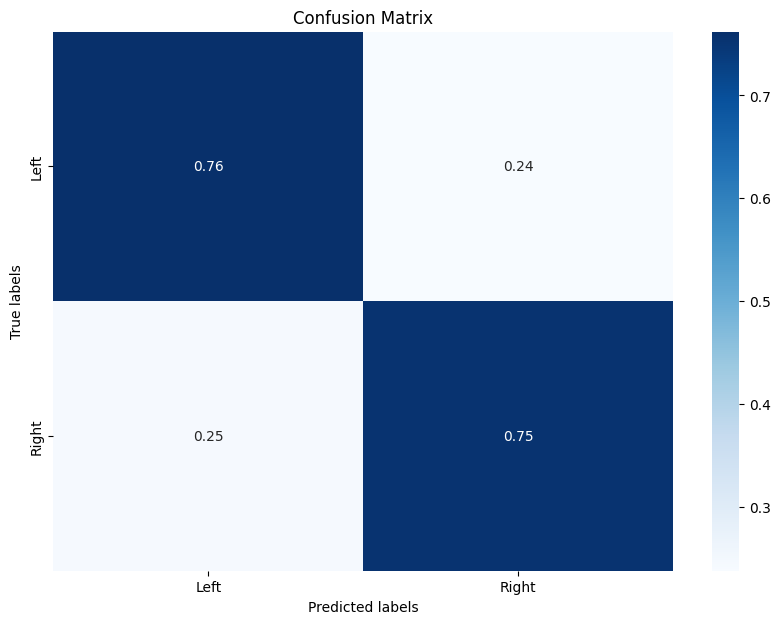

In [24]:
classes_list = ['Left', 'Right']
eval_model = EvalModel(trained_eegnet_model)
test_accuracy = eval_model.test_model(test_dataset)
eval_model.plot_confusion_matrix(test_dataset, classes_list)

# 5. Evaluacion del modelo manual

In [25]:
!unzip true_labels.zip -d five_session_labels

Archive:  true_labels.zip
replace five_session_labels/B0401T.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: five_session_labels/B0401T.mat  
  inflating: five_session_labels/B0403T.mat  
  inflating: five_session_labels/B0601T.mat  
  inflating: five_session_labels/B0202T.mat  
  inflating: five_session_labels/B0603T.mat  
  inflating: five_session_labels/B0104E.mat  
  inflating: five_session_labels/B0105E.mat  
  inflating: five_session_labels/B0802T.mat  
  inflating: five_session_labels/B0305E.mat  
  inflating: five_session_labels/B0501T.mat  
  inflating: five_session_labels/B0405E.mat  
  inflating: five_session_labels/B0702T.mat  
  inflating: five_session_labels/B0705E.mat  
  inflating: five_session_labels/B0605E.mat  
  inflating: five_session_labels/B0904E.mat  
  inflating: five_session_labels/B0203T.mat  
  inflating: five_session_labels/B0103T.mat  
  inflating: five_session_labels/B0404E.mat  
  inflating: five_session_labels/B0701T.mat  
  inflating: five_se

In [26]:
raw_data_folder = 'raw_data/'
cleaned_data_folder = 'cleaned_data/five_session/'
mat_folder = 'five_session_labels/'

# Filtrar archivos .mat para las etiquetas (ejemplo 4E.mat)
mat_files = os.listdir(mat_folder)
filtered_math_labels = [file for file in mat_files if file.endswith('05E.mat')]

# Filtrar archivos .gdf para la sesión (ejemplo 4E.gdf)
files = os.listdir(raw_data_folder)
filtered_files = [file for file in files if file.endswith('05E.gdf')]

raw_list = []

#Array de five_session_labels
five_session_labels = np.array([])

# Iteración sobre los .gdf
for file in filtered_files:
    file_path = os.path.join(raw_data_folder, file)

    # Leer datos
    raw = mne.io.read_raw_gdf(file_path,
                              eog=['EOG-left', 'EOG-central', 'EOG-right'],
                              preload=True)
    raw.drop_channels(['EOG:ch01', 'EOG:ch02', 'EOG:ch03'])
    raw.filter(l_freq=8, h_freq=30, method='iir')

    # Guardar .fif
    new_file_path = os.path.join(cleaned_data_folder, file[:-4] + '.fif')
    raw.save(new_file_path, overwrite=True)

    raw_list.append(raw)

    # Cargar labels del .mat correspondiente
    mat_file_name = file.replace('.gdf', '.mat')
    mat_file_path = os.path.join(mat_folder, mat_file_name)
    print(f"data:{file}, label:{mat_file_name}")

    if os.path.exists(mat_file_path):
        mat_data = scipy.io.loadmat(mat_file_path)
        class_labels = mat_data.get('classlabel', [])

        if class_labels.size > 0:
            class_labels_array = np.array(class_labels, dtype=int).flatten()
            five_session_labels = np.concatenate(
                (five_session_labels, class_labels_array)
            )
            print(f"Etiquetas cargadas: {class_labels_array.shape[0]}")
        else:
            print(f"Warning: 'classlabel' not found or empty in {mat_file_name}.")
    else:
        print(f"Warning: {mat_file_name} not found.")

# Concatenamos todos los raws
final_raw = mne.concatenate_raws(raw_list)
new_file_path = os.path.join(cleaned_data_folder, 'Five_Session_Subjects.fif')
final_raw.save(new_file_path, overwrite=True)

Extracting EDF parameters from /content/raw_data/B0905E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 458570  =      0.000 ...  1834.280 secs...


/tmp/ipython-input-1331448909.py:23: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path,


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Overwriting existing file.
Writing /content/cleaned_data/five_session/B0905E.fif
Overwriting existing file.
Closing /content/cleaned_data/five_session/B0905E.fif
[done]
data:B0905E.gdf, label:B0905E.mat
Etiquetas cargadas: 160
Extracting EDF parameters from /content/raw_data/B0805E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 464306  =      0.000 ...  1857.224 secs...


/tmp/ipython-input-1331448909.py:31: RuntimeWarning: This filename (/content/cleaned_data/five_session/B0905E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)
/tmp/ipython-input-1331448909.py:23: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path,


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Overwriting existing file.
Writing /content/cleaned_data/five_session/B0805E.fif
Overwriting existing file.
Closing /content/cleaned_data/five_session/B0805E.fif
[done]
data:B0805E.gdf, label:B0805E.mat
Etiquetas cargadas: 160
Extracting EDF parameters from /content/raw_data/B0705E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 460894  =      0.000 ...  1843.576 secs...


/tmp/ipython-input-1331448909.py:31: RuntimeWarning: This filename (/content/cleaned_data/five_session/B0805E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)
/tmp/ipython-input-1331448909.py:23: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path,


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Overwriting existing file.
Writing /content/cleaned_data/five_session/B0705E.fif
Overwriting existing file.
Closing /content/cleaned_data/five_session/B0705E.fif
[done]
data:B0705E.gdf, label:B0705E.mat
Etiquetas cargadas: 160
Extracting EDF parameters from /content/raw_data/B0105E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 474362  =      0.000 ...  1897.448 secs...


/tmp/ipython-input-1331448909.py:31: RuntimeWarning: This filename (/content/cleaned_data/five_session/B0705E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)
/tmp/ipython-input-1331448909.py:23: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path,


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Overwriting existing file.
Writing /content/cleaned_data/five_session/B0105E.fif
Overwriting existing file.
Closing /content/cleaned_data/five_session/B0105E.fif
[done]
data:B0105E.gdf, label:B0105E.mat
Etiquetas cargadas: 160
Extracting EDF parameters from /content/raw_data/B0605E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 460902  =      0.000 ...  1843.608 secs...


/tmp/ipython-input-1331448909.py:31: RuntimeWarning: This filename (/content/cleaned_data/five_session/B0105E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)
/tmp/ipython-input-1331448909.py:23: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path,


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Overwriting existing file.
Writing /content/cleaned_data/five_session/B0605E.fif
Overwriting existing file.
Closing /content/cleaned_data/five_session/B0605E.fif
[done]
data:B0605E.gdf, label:B0605E.mat
Etiquetas cargadas: 160
Extracting EDF parameters from /content/raw_data/B0305E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 463618  =      0.000 ...  1854.472 secs...


/tmp/ipython-input-1331448909.py:31: RuntimeWarning: This filename (/content/cleaned_data/five_session/B0605E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)
/tmp/ipython-input-1331448909.py:23: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path,


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Overwriting existing file.
Writing /content/cleaned_data/five_session/B0305E.fif
Overwriting existing file.
Closing /content/cleaned_data/five_session/B0305E.fif
[done]
data:B0305E.gdf, label:B0305E.mat
Etiquetas cargadas: 160
Extracting EDF parameters from /content/raw_data/B0505E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 464958  =      0.000 ...  1859.832 secs...


/tmp/ipython-input-1331448909.py:31: RuntimeWarning: This filename (/content/cleaned_data/five_session/B0305E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)
/tmp/ipython-input-1331448909.py:23: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path,


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Overwriting existing file.
Writing /content/cleaned_data/five_session/B0505E.fif
Overwriting existing file.
Closing /content/cleaned_data/five_session/B0505E.fif
[done]
data:B0505E.gdf, label:B0505E.mat
Etiquetas cargadas: 160
Extracting EDF parameters from /content/raw_data/B0205E.gdf...


/tmp/ipython-input-1331448909.py:31: RuntimeWarning: This filename (/content/cleaned_data/five_session/B0505E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 473686  =      0.000 ...  1894.744 secs...


/tmp/ipython-input-1331448909.py:23: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path,


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Overwriting existing file.
Writing /content/cleaned_data/five_session/B0205E.fif
Overwriting existing file.


/tmp/ipython-input-1331448909.py:31: RuntimeWarning: This filename (/content/cleaned_data/five_session/B0205E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/five_session/B0205E.fif
[done]
data:B0205E.gdf, label:B0205E.mat
Etiquetas cargadas: 160
Extracting EDF parameters from /content/raw_data/B0405E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 466050  =      0.000 ...  1864.200 secs...


/tmp/ipython-input-1331448909.py:23: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path,


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Overwriting existing file.
Writing /content/cleaned_data/five_session/B0405E.fif
Overwriting existing file.
Closing /content/cleaned_data/five_session/B0405E.fif
[done]
data:B0405E.gdf, label:B0405E.mat
Etiquetas cargadas: 160


/tmp/ipython-input-1331448909.py:31: RuntimeWarning: This filename (/content/cleaned_data/five_session/B0405E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Overwriting existing file.
Writing /content/cleaned_data/five_session/Five_Session_Subjects.fif
Overwriting existing file.


/tmp/ipython-input-1331448909.py:58: RuntimeWarning: This filename (/content/cleaned_data/five_session/Five_Session_Subjects.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  final_raw.save(new_file_path, overwrite=True)


Closing /content/cleaned_data/five_session/Five_Session_Subjects.fif
[done]


[PosixPath('/content/cleaned_data/five_session/Five_Session_Subjects.fif')]

In [31]:
# Cargar el archivo .mat que tiene las etiquetas
mat_data = loadmat("five_session_labels/B0105E.mat")   # ajusta con tu archivo real
labels_mat = mat_data['classlabel'].squeeze()  # (160,)
print(labels_mat.shape)  # debería dar (160,)

print("Total etiquetas:", labels_mat.shape[0])
print("Ejemplo de clases únicas:", np.unique(labels_mat))


(160,)
Total etiquetas: 160
Ejemplo de clases únicas: [1 2]


In [32]:
events, event_dict = mne.events_from_annotations(final_raw)
events[1]

# Mostrar los eventos únicos encontrados
print("Eventos encontrados:", event_dict)

print(events.shape)
print(events[:5])  # Primeros 5 eventos

epochs = mne.Epochs(final_raw, events, event_id=11, tmin=0.5, tmax=4, reject=None, baseline=None, preload=None)

five_session_data = epochs.get_data(copy=True)

print("Five Session Dataset shape:", five_session_data.shape)
print("Total etiquetas cargadas:", five_session_labels.shape)

Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('781'), np.str_('783')]
Eventos encontrados: {np.str_('1023'): 1, np.str_('1077'): 2, np.str_('1078'): 3, np.str_('1079'): 4, np.str_('1081'): 5, np.str_('276'): 6, np.str_('277'): 7, np.str_('32766'): 8, np.str_('768'): 9, np.str_('781'): 10, np.str_('783'): 11}
(4743, 3)
[[    0     0     8]
 [  499     0     6]
 [16749     0     7]
 [32999     0     5]
 [37999     0     4]]
Not setting metadata
1440 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1440 events and 876 original time points ...
0 bad epochs dropped
Five Session Dataset shape: (1440, 3, 876)
Total etiquetas cargadas: (1440,)


In [33]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# -------------------------------
# 1. Definir el modelo y cargar pesos
# -------------------------------
model = EEGNetModel(
    chans=3,
    classes=2,
    time_points=876,
    temp_kernel=32,
    f1=16,
    f2=32,
    d=2,
    pk1=8,
    pk2=16,
    dropout_rate=0.5,
    max_norm1=1,
    max_norm2=0.25
)

# Cargar pesos entrenados
model.load_state_dict(torch.load("eegnet2b_model.pth", map_location=device))
model = model.to(device)
model.eval()

# -------------------------------
# 2. Preparar datos de five_session
# -------------------------------
# Normalizar etiquetas (de {1,2} → {0,1})
y_five = five_session_labels - np.min(five_session_labels)

# Normalizar características (z-score global)
X_five = (five_session_data - np.mean(five_session_data)) / np.std(five_session_data)

# Convertir a tensores [batch, 1, chans, time_points]
X_five = torch.Tensor(X_five).unsqueeze(1).to(device)   # [1440, 1, 3, 1001]
y_five = torch.LongTensor(y_five).to(device)

# Crear dataset y dataloader
test_dataset = TensorDataset(X_five, y_five)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print("Size of X_five:", X_five.size())  # Debe ser [1440, 1, 3, 1001]
print("Size of y_five:", y_five.size())

# -------------------------------
# 3. Evaluación manual
# -------------------------------
correct = 0
total = 0

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Evento real tomado de epochs.events
        true_event = epochs.events[i, 2]

        print(f"Epoch {i}: etiqueta real = {labels.item()}, evento = {true_event}, predicción = {predicted.item()}")

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"\nPrecisión total: {accuracy:.2f}%")
print("Dimensiones:", len(five_session_labels), len(five_session_data), len(epochs.events))



Size of X_five: torch.Size([1440, 1, 3, 876])
Size of y_five: torch.Size([1440])
Epoch 0: etiqueta real = 0, evento = 11, predicción = 0
Epoch 1: etiqueta real = 1, evento = 11, predicción = 0
Epoch 2: etiqueta real = 0, evento = 11, predicción = 0
Epoch 3: etiqueta real = 1, evento = 11, predicción = 1
Epoch 4: etiqueta real = 1, evento = 11, predicción = 0
Epoch 5: etiqueta real = 1, evento = 11, predicción = 1
Epoch 6: etiqueta real = 0, evento = 11, predicción = 0
Epoch 7: etiqueta real = 1, evento = 11, predicción = 1
Epoch 8: etiqueta real = 0, evento = 11, predicción = 0
Epoch 9: etiqueta real = 0, evento = 11, predicción = 0
Epoch 10: etiqueta real = 0, evento = 11, predicción = 0
Epoch 11: etiqueta real = 1, evento = 11, predicción = 1
Epoch 12: etiqueta real = 0, evento = 11, predicción = 0
Epoch 13: etiqueta real = 0, evento = 11, predicción = 0
Epoch 14: etiqueta real = 1, evento = 11, predicción = 1
Epoch 15: etiqueta real = 1, evento = 11, predicción = 1
Epoch 16: etiquet